<a href="https://colab.research.google.com/github/Kulikov17/seo-optimization-product-cards/blob/main/notebooks/fashion_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import sklearn.metrics as metrics

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
train_set = torchvision.datasets.FashionMNIST("../data",
                                              download=True,
                                              transform=transform)

In [7]:
test_set = torchvision.datasets.FashionMNIST("../data",
                                             download=True,
                                             train=False,
                                             transform=transform)

In [76]:
# Number of threads for data loader
NUM_WORKERS = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 5

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

In [77]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=NUM_WORKERS,
)

We have 10 types of clothes in FashionMNIST dataset.

In [78]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Building a CNN

In [79]:
class FashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionCNN, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)
        # Fully Connected 1
        self.fc1 = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2
        out = self.maxpool2(out)
        # Resize
        out = out.view(out.size(0), -1)
        # Dropout
        out = self.dropout(out)
        # Fully connected 1
        out = self.fc1(out)
        return out

In [80]:
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


Training a network and Testing it on test dataset

In [81]:
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(EPOCH_NUM):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        count += 1

        # Testing the model

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                outputs = model(images)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data.cpu().numpy())
            iteration_list.append(count)
            accuracy_list.append(accuracy.cpu().numpy())

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,
                                                                  loss.data,
                                                                  accuracy))


Iteration: 500, Loss: 0.33996233344078064, Accuracy: 84.1500015258789%
Iteration: 1000, Loss: 0.24644143879413605, Accuracy: 86.4000015258789%
Iteration: 1500, Loss: 0.212323859333992, Accuracy: 87.31999969482422%
Iteration: 2000, Loss: 0.362811416387558, Accuracy: 88.08999633789062%


Visualizing the Loss and Accuracy with Iterations

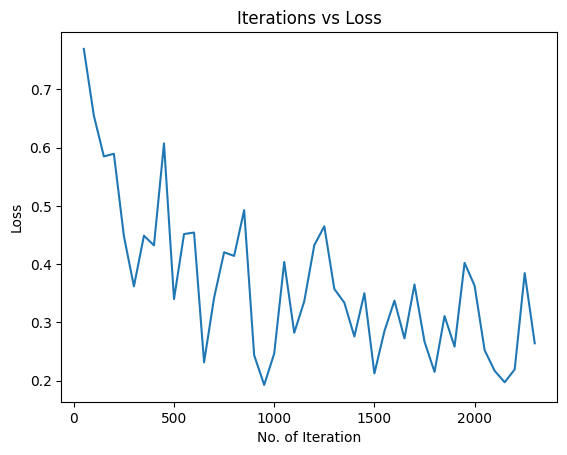

In [82]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

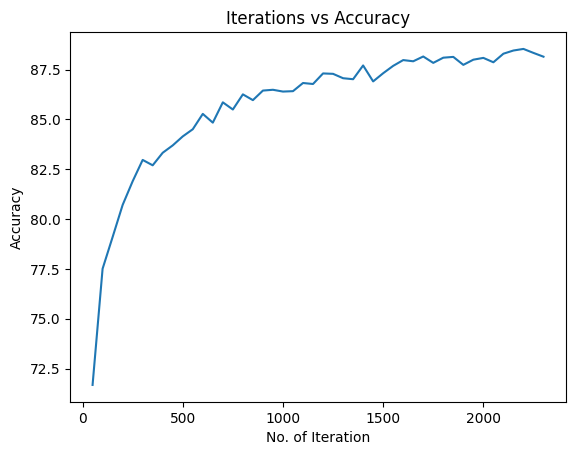

In [83]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

Looking the Accuracy in each class of FashionMNIST dataset

Printing the Confusion Matrix

In [86]:
from itertools import chain

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [87]:
metrics.confusion_matrix(labels_l, predictions_l)

print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     46000
           1       0.98      0.96      0.97     46000
           2       0.77      0.78      0.78     46000
           3       0.85      0.88      0.86     46000
           4       0.75      0.76      0.76     46000
           5       0.96      0.95      0.95     46000
           6       0.63      0.58      0.61     46000
           7       0.92      0.94      0.93     46000
           8       0.95      0.96      0.96     46000
           9       0.95      0.95      0.95     46000

    accuracy                           0.86    460000
   macro avg       0.86      0.86      0.86    460000
weighted avg       0.86      0.86      0.86    460000


